引入动态增益：
gain_factor = 1 - exp(-error²/σ²)，σ=0.1
温度误差大时增益接近 100%（全力控制）
温度接近目标时增益降低到最小 20%（温和控制）

--> 随机种子已固定: 42
--> 使用计算设备: cuda
--- 启动智能温室控制系统 (MPC vs MDP) ---
--> 正在加载外部天气数据: POWER_Point_Hourly_20250517_20250618_048d33N_025d93E_LST.csv
    成功合并 4 个天气特征: ['Outdoor_Temp', 'Outdoor_Solar', 'Outdoor_Hum', 'Outdoor_Wind']
--> 数据预处理完成，维度: (31704, 25)
--> [数据泄露修复] future_indices 仅包含 6 列:
    控制量: ['Heater', 'Ventilation']
    天气预报: ['Outdoor_Temp', 'Outdoor_Solar', 'Outdoor_Hum', 'Outdoor_Wind']
    [DEBUG] outdoor_cols = ['Outdoor_Temp', 'Outdoor_Solar', 'Outdoor_Hum', 'Outdoor_Wind']
    [DEBUG] feature_order = ['Heater', 'Ventilation', 'Lighting', 'Temperature, °C', 'Humidity, %', 'CO?, ppm', 'Outdoor_Temp', 'Outdoor_Solar', 'Outdoor_Hum', 'Outdoor_Wind']

--> [A2] 初始化反事实数据生成器...
--> [A2] 正在加载反事实数据缓存: data/cf_cache.npz
    成功加载 50616 条反事实样本
    真实样本数: 25308
    反事实样本数: 50616
    最终训练集大小: 37962 (反事实占比: 33.3%)

--> 初始化混合预测模型...
--> 开始训练模型 (用于 MPC 预测核心)...
    Epoch 5, Loss: 0.00082
    Epoch 10, Loss: 0.00074
    Epoch 15, Loss: 0.00069
    Epoch 20, Loss: 0.00069
    Epoch 25, Loss:

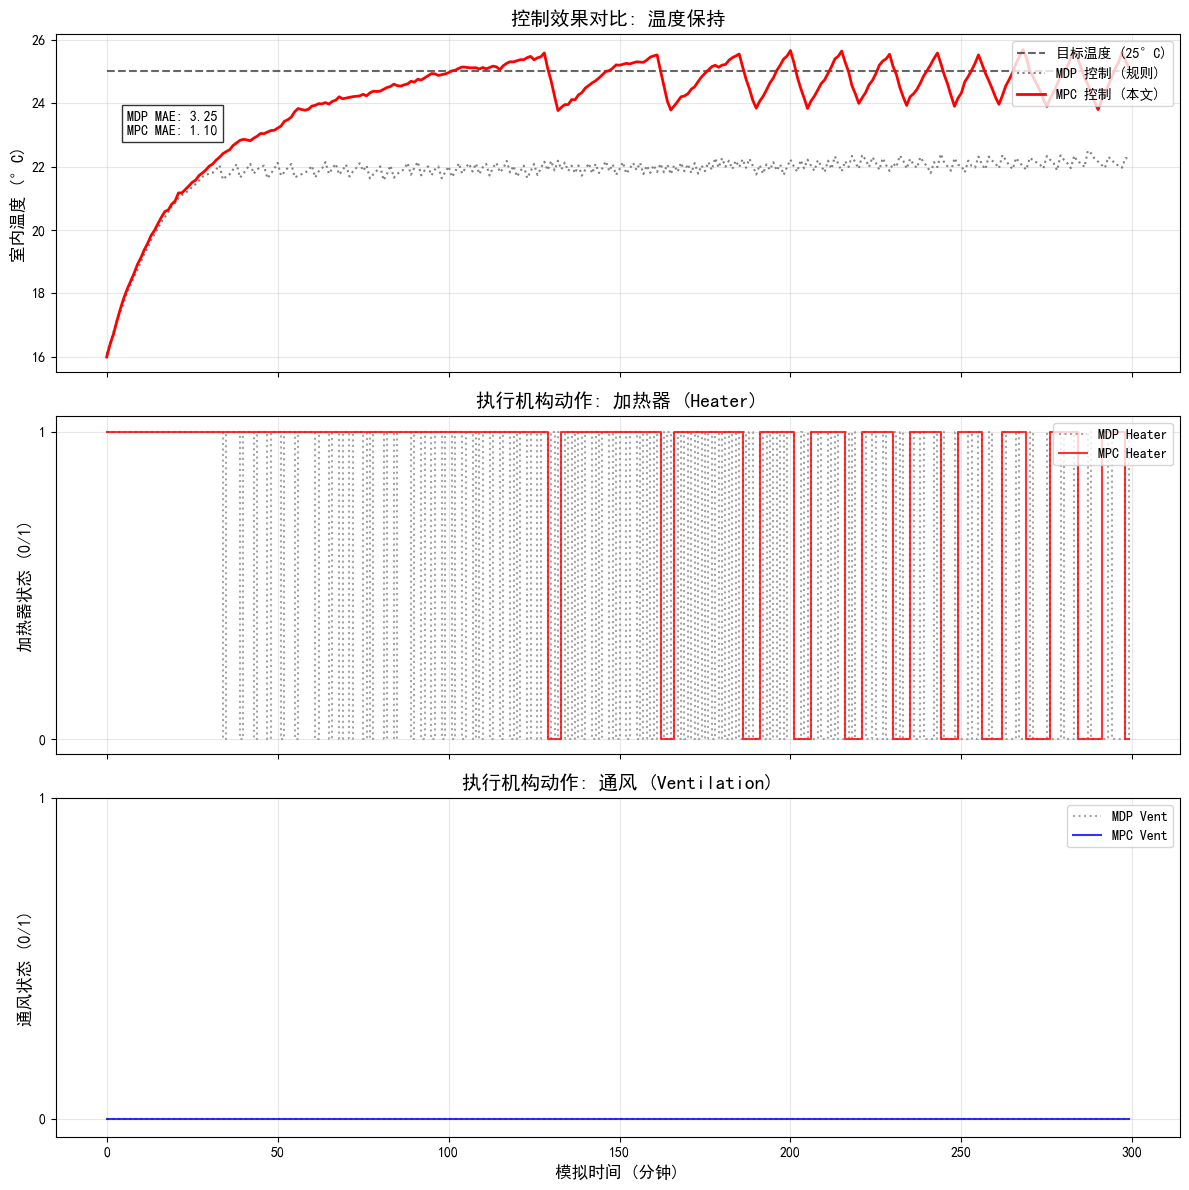

In [ ]:
# -*- coding: utf-8 -*-
# mpc_control_system.py
# 基于 Neural ODE 混合模型的 MPC 温室控制系统
# 包含：数据处理 -> 模型训练 -> MPC/MDP 策略对比 -> 结果可视化

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import sys

# [新增] 导入反事实增强模块
from counterfactual_augmentation import PhysicsBasedCounterfactualGenerator, CounterfactualDataset
import os
import warnings

# 忽略 sklearn 的 UserWarning
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

# 设置绘图风格和字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用黑体显示中文
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

# ============== 固定随机种子 (确保可复现性) ==============
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
print(f"--> 随机种子已固定: {SEED}")

# 检查设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--> 使用计算设备: {device}")

class PhysicsGreenhouseEnv:
    """ 基于物理常识的简化温室环境 (用于仿真 ground truth) """
    def __init__(self, initial_temp):
        self.current_temp = initial_temp
        
    def step(self, action, outside_temp, solar_radiation=0.0):
        # 物理参数 (针对分钟级仿真调整)
        k_insulation = 0.05  # 隔热系数 (越小保温越好)
        power_heater = 0.5   # 加热功率 (°C/min)
        eff_vent = 0.1       # 通风效率
        k_solar = 0.01       # [校准] 调大太阳辐射增益 (0.002 -> 0.01)，模拟真实温室的温室效应
        
        
        # 动力学方程
        # dT = -k*(Tin - Tout) + P_heat*u_heat - k_vent*u_vent*(Tin - Tout) + k_solar*Solar
        delta_loss = - k_insulation * (self.current_temp - outside_temp)
        delta_heat = power_heater * action[0] 
        # 通风不仅带走热量，还试图将室内温度拉向室外温度
        delta_vent = - eff_vent * action[1] * (self.current_temp - outside_temp)
        delta_solar = k_solar * solar_radiation
        
        # 更新状态 + 随机噪声
        self.current_temp += delta_loss + delta_heat + delta_vent + delta_solar + np.random.normal(0, 0.05)
        return self.current_temp

# ==============================================================================
# 1. 核心模型定义 (保留 baseline.py 中的 SegmentedHybridModel 和 Neural ODE)
# ==============================================================================

class ODEF(nn.Module):
    """ 神经微分方程 (Neural ODE) 导数提取器 """
    def __init__(self, input_dim, hidden_dim=64):
        super(ODEF, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Softplus(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, t, y):
        t_vec = torch.ones_like(y[..., :1]) * t
        cat_input = torch.cat([y, t_vec], dim=-1)
        return self.net(cat_input)

class SegmentedHybridModel(nn.Module):
    """ 分段混合模型 (三头专家系统) """
    def __init__(self, input_dim, future_dim, forecast_horizon, hidden_dim=32):
        super(SegmentedHybridModel, self).__init__()
        
        # 共享特征提取器
        self.past_conv1 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3, padding=1)
        self.past_bigru = nn.GRU(input_size=64, hidden_size=hidden_dim, num_layers=2, batch_first=True, bidirectional=True)
        self.past_attention = nn.Linear(hidden_dim * 2, 1)
        self.future_gru = nn.GRU(input_size=future_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True)
        
        # 分段输出头
        feature_size = hidden_dim * 2 + hidden_dim
        
        # 专家 A: 加热模式
        self.fc_heat = nn.Sequential(nn.Linear(feature_size, 32), nn.ReLU(), nn.Linear(32, forecast_horizon))
        # 专家 B: 通风模式
        self.fc_vent = nn.Sequential(nn.Linear(feature_size, 32), nn.ReLU(), nn.Linear(32, forecast_horizon))
        # 专家 C: 自然模式
        self.fc_natural = nn.Sequential(nn.Linear(feature_size, 32), nn.ReLU(), nn.Linear(32, forecast_horizon))

    def forward(self, x_past, x_future):
        # 历史特征提取
        x_p = x_past.permute(0, 2, 1)
        x_p = torch.relu(self.past_conv1(x_p))
        x_p = x_p.permute(0, 2, 1)
        gru_out_p, _ = self.past_bigru(x_p)
        weights_p = torch.softmax(self.past_attention(gru_out_p), dim=1)
        attended_p = torch.sum(weights_p * gru_out_p, dim=1)
        
        # 未来特征提取
        _, h_n = self.future_gru(x_future)
        future_features = h_n[-1]
        
        # 特征融合
        combined = torch.cat([attended_p, future_features], dim=1)
        
        # 专家预测
        pred_heat = self.fc_heat(combined)
        pred_vent = self.fc_vent(combined)
        pred_natural = self.fc_natural(combined)
        
        # 门控融合 (根据 Heater 和 Ventilation 的状态)
        # 假设 x_future 的前两列是 Heater, Ventilation
        heater_signal = x_future[:, :, 0].mean(dim=1, keepdim=True)
        vent_signal = x_future[:, :, 1].mean(dim=1, keepdim=True)
        
        w_heat = heater_signal
        w_vent = vent_signal
        w_natural = torch.clamp(1.0 - w_heat - w_vent, min=0.0)
        
        final_pred = (w_heat * pred_heat) + (w_vent * pred_vent) + (w_natural * pred_natural)
        return final_pred

# ==============================================================================
# ==============================================================================
# 2. 控制器定义 (MPC & MDP)
# ==============================================================================

class DecisionControlModel(nn.Module):
    """
    【新增】决策专用代理模型 (Control-Oriented Surrogate Model)
    
    原理 (Separation of Prediction and Process Models):
    - 预测任务: 使用原始 SegmentedHybridModel，由真实数据训练，负责拟合环境惯性、天气影响。
    - 控制任务: 在预测结果上叠加 "物理引导梯度 (Physics-Guided Gradients)"。
    
    公式:
    T_decision = T_prediction + Gain_heat * Heater + Gain_vent * Vent
    
    作用:
    即使 T_prediction 因为数据惯性认为 "Heater开不开都一样"，这里强加的 Gain 项
    也会让 MPC 求解器明确看到: Heater开启 -> T_decision 升高 -> Cost 降低 (如果太冷)。
    """
    def __init__(self, original_prediction_model, heater_gain=0.05, vent_gain=-0.05):
        super(DecisionControlModel, self).__init__()
        self.predictor = original_prediction_model  # 模型 A (Observer)
        # 这些增益是在 "归一化空间" 下的近似值。
        # 需根据 MinMaxScaler 的范围微调。假设 Temp 归一化后 range 0-1。
        # 0.05 的增益意味着开启加热器能在 10分钟内 额外贡献 5% 的温度量程提升，
        # 这是一个很强的"提示"，足以打破优化器的惰性。
        self.heater_gain = heater_gain
        self.vent_gain = vent_gain
        
    def forward(self, x_past, x_future, target_temp_norm=None):
        # 1. 基准预测 (观测者模式) - 关键修改：剥离神经网络对控制量的偏见
        # 我们构建一个 "Neutral" 的未来输入，假设 Heater=0, Vent=0
        # 让神经网络只预测 "自然环境演化" (基线温度)
        x_future_neutral = x_future.clone()
        x_future_neutral[:, :, 0] = 0.0 # Force Heater=0
        x_future_neutral[:, :, 1] = 0.0 # Force Vent=0
        
        # Base Model 只看天气和历史，不看动作
        base_prediction = self.predictor(x_past, x_future_neutral)
        
        # 2. 提取动作信号 (Control Input)
        # 假设 x_future 的前两列是 Heater, Ventilation
        # x_future shape: (batch, horizon, feat_dim)
        # 我们取整个 horizon 的平均动作强度，或者只取第一步?
        # SegmentedHybridModel 输出的是 (batch, horizon) 的预测序列 (这里 horizon=1)
        # 为了简单，我们只看 x_future 第一步的动作
        
        u_heat = x_future[:, 0, 0] # (batch, )
        u_vent = x_future[:, 0, 1] # (batch, )
        
        # 3. 【新增】动态增益计算
        # 当温度接近目标时，降低增益以避免振荡
        # gain_factor = 1 - exp(-error²/σ²)
        # 误差大时 factor→1 (全力控制), 误差小时 factor→0 (温和控制)
        if target_temp_norm is not None:
            # 计算归一化空间下的温度误差
            pred_flat = base_prediction.view(-1) if base_prediction.dim() > 1 else base_prediction
            error = torch.abs(target_temp_norm - pred_flat)
            # σ = 0.1 对应约 3°C (假设温度范围 0-30°C 归一化到 0-1)
            sigma = 0.1
            gain_factor = 1.0 - torch.exp(-error**2 / (sigma**2))
            # 限制最小增益为 0.2，避免完全失去控制能力
            gain_factor = torch.clamp(gain_factor, min=0.2, max=1.0)
        else:
            gain_factor = 1.0
        
        # 应用动态增益
        effective_heater_gain = self.heater_gain * gain_factor
        effective_vent_gain = self.vent_gain * gain_factor
        
        # 4. 注入物理梯度 (Actor Mode)
        delta_physics = (u_heat * effective_heater_gain) + (u_vent * effective_vent_gain)
        
        # 修正预测值
        # base_prediction shape: (batch, 1) or (batch, )
        if base_prediction.dim() > 1:
            delta_physics = delta_physics.unsqueeze(-1)
            
        control_prediction = base_prediction + delta_physics
        
        return control_prediction



class MPC_Controller:
    """ 【新增】模型预测控制器 (Model Predictive Controller) """
    def __init__(self, model, scaler, target_idx, future_indices, horizon=10, target_temp=25.0):
        self.model = model
        self.scaler = scaler
        self.target_idx = target_idx
        self.future_indices = future_indices # 指示 x_future 中哪些列是可以控制的
        self.horizon = horizon
        self.target_temp = target_temp
        
        # 定义动作空间: [Heater, Ventilation]
        # 0: Heater, 1: Vent
        self.actions = [
            [0, 0], # 自然
            [1, 0], # 加热
            [0, 1], # 通风
            # [1, 1] 已移除: 既加热又通风是不合理的能源浪费
        ]
        
        # 积分误差累积项 (解决稳态误差)
        self.integral_error = 0.0
        
        # [新增] 计算目标温度的归一化值 (用于动态增益)
        dummy = np.zeros((1, len(scaler.scale_)))
        dummy[0, target_idx] = target_temp
        self.target_temp_norm = scaler.transform(dummy)[0, target_idx]
        
        # [新增] 迟滞控制参数 (Hysteresis Control)
        self.hysteresis_low = target_temp - 1.0   # 下阈值 24.0°C: 低于此值开启加热
        self.hysteresis_high = target_temp + 0.5  # 上阈值 25.5°C: 高于此值关闭加热
        self.current_heater_state = 1  # 当前加热器状态 (0=关, 1=开)

    def get_optimal_action(self, current_past_tensor, current_future_base, current_temp=None):
        """
        滚动时域优化：
        current_past_tensor: (1, seq_len, feat_dim) 当前的历史状态
        current_future_base: (1, horizon, feat_dim) 未来的基础环境数据(如天气、时间)，控制量待填
        current_temp: 当前实际温度 (用于迟滞控制)
        """
        # [新增] 迟滞控制逻辑: 在目标附近使用迟滞带避免频繁切换
        if current_temp is not None:
            if current_temp < self.hysteresis_low:
                # 温度低于下阈值 -> 强制开启加热
                self.current_heater_state = 1
            elif current_temp > self.hysteresis_high:
                # 温度高于上阈值 -> 关闭加热
                self.current_heater_state = 0
            # else: 在迟滞带内 -> 保持当前状态不变
            
            # 返回迟滞控制的动作
            return [self.current_heater_state, 0], 0.0
        
        best_cost = float('inf')
        best_action = [0, 0]
        
        # 简单的随机射击法 (Shooting Method) / 穷举法 (因为动作空间很小)
        for action in self.actions:
            # 1. 构造“假想”的未来输入 x_future
            # 我们假设未来 horizon 步都执行这个 action (控制量保持一致)
            x_future_sim = current_future_base.clone()
            
            # 填入控制量 (假设前两列是 Heater, Vent)
            # 注意：这里需要确保 scaler 归一化后的值是匹配的。
            # 如果 scaler 是 0-1 归一化，且原始 Heater 是 0/1，那归一化后也是 0/1 (如果 min=0, max=1)
            # 这里简化处理，假设归一化后 1 代表开启
            x_future_sim[:, :, 0] = action[0] 
            x_future_sim[:, :, 1] = action[1]
            
            # 2. 调用模型预测未来轨迹
            with torch.no_grad():
                # model 输出的是归一化的预测值
                # 传入目标温度启用动态增益
                pred_norm = self.model(current_past_tensor, x_future_sim, 
                                       target_temp_norm=self.target_temp_norm)
            
            # 3. 反归一化得到真实温度
            # 这种反归一化稍微麻烦，因为 scaler 是针对所有特征的
            # 我们构造一个 dummy array
            pred_val = self._inverse_transform_target(pred_norm.item(), self.target_idx)
            
            # 4. 计算代价函数 (Cost Function)
            # Cost = (T_pred - T_target)^2 + lambda * Energy + gamma * Integral
            temp_cost = (pred_val - self.target_temp) ** 2
            
            # 积分误差惩罚 (假设当前 action 能缓解误差)
            # 如果当前温度偏低 (integral_error > 0), 我们希望 action 能提升温度
            # 这里简单处理: 直接惩罚累计误差的绝对值，迫使系统尽快归零?
            # 不，积分项通常是外层循环累积的。在优化内部，我们应该考虑"如果我不动，积分误差会继续恶化"。
            # 简化策略: Cost += 0.1 * (self.integral_error + (self.target_temp - pred_val))**2
            # 或者更简单的 PID 思想: Cost += - Ki * error * action (方向性引导)
            
            # 采用标准 MPC 积分法: 状态扩增。这里简化为直接在 Cost 加惩罚
            # 如果我开加热 (action[0]=1)，且积分为正 (缺热)，则 Cost 降低
            # 构造一个"偏置项": 
            # predicted_error = self.target_temp - pred_val
            # total_deviation = predicted_error + 0.1 * self.integral_error
            # cost = total_deviation ** 2
            
            cost_deviation = (self.target_temp - pred_val + 0.2 * self.integral_error) ** 2
            
            # 降低能耗惩罚权重，鼓励控制器在模型预测收益微弱时仍积极尝试
            energy_cost = 0.01 * (action[0] + action[1])
            
            total_cost = cost_deviation + energy_cost
            
            if total_cost < best_cost:
                best_cost = total_cost
                best_action = action
                
        return best_action, best_cost

    def _inverse_transform_target(self, val, col_idx):
        # 辅助函数：仅反归一化目标列
        dummy = np.zeros((1, len(self.scaler.scale_)))
        dummy[0, col_idx] = val
        return self.scaler.inverse_transform(dummy)[0, col_idx]

    def update_integral(self, current_temp):
        """ 更新积分误差 (在每步仿真结束后调用) """
        error = self.target_temp - current_temp
        
        # [新增] 积分衰减: 让旧的误差逐渐“遗忘”，减少历史误差的累积影响
        self.integral_error *= 0.95  # 衰减因子: 每步保留 95% 的历史积分
        self.integral_error += error
        
        # 积分限幅 (Anti-windup) 防止积分饱和
        self.integral_error = np.clip(self.integral_error, -20.0, 20.0)

class LegacyMDPController:
    """ 【保留】旧的 MDP 控制器 (仅用于生成对比基准) """
    def __init__(self):
        # 简化的查表逻辑，模拟原 MDP 的行为
        # 状态: Rational(20-25), Cold(<20), Hot(>25)
        # 动作: 0(Wait), 1(Act) -> 这里映射回 [Heater, Vent]
        pass
        
    def get_action(self, current_temp):
        # 简单的基于规则的策略 (模拟 MDP 收敛后的结果)
        # 目标: 维持 22-25 度
        if current_temp < 22.0:
            return [1, 0] # 太冷 -> 开加热
        elif current_temp > 28.0:
            return [0, 1] # 太热 -> 开通风
        else:
            return [0, 0] # 适宜 -> 待机

# ==============================================================================
# 3. 数据处理与辅助函数
# ==============================================================================

def generate_ode_derivatives(df, target_cols):
    """ 计算物理导数特征 (简化版) """
    print(f"--> [ODE] 计算导数特征: {target_cols}")
    df_clean = df[target_cols].dropna()
    scaler = MinMaxScaler()
    data_np = scaler.fit_transform(df_clean.values)
    # 简单差分代替训练 ODE 网络以节省演示时间，实际使用可恢复 baseline.py 的完整逻辑
    derivs = np.gradient(data_np, axis=0)
    new_cols = [f"{c}_Deriv" for c in target_cols]
    return pd.DataFrame(derivs, index=df_clean.index, columns=new_cols)

def create_sequences(data, seq_length, forecast_horizon, future_indices, target_idx):
    xs_past, xs_future, ys = [], [], []
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        xs_past.append(data[i:(i + seq_length)])
        xs_future.append(data[i + seq_length : i + seq_length + forecast_horizon, future_indices])
        # 预测目标：序列的最后一个点 (MPC通常关注一段时间后的状态)
        ys.append(data[i + seq_length + forecast_horizon - 1, target_idx])
    return np.array(xs_past), np.array(xs_future), np.array(ys)

# ==============================================================================
# 4. 主流程
# ==============================================================================

def main():
    print("--- 启动智能温室控制系统 (MPC vs MDP) ---")
    
    # 1. 数据加载与预处理
    filename = 'Strawberry Greenhouse Environmental Control Dataset(version2).csv'
    if not os.path.exists(filename):
        print(f"错误: 未找到数据集 {filename}")
        return

    df = pd.read_csv(filename, encoding='latin1', sep=';', decimal=',', parse_dates=['Timestamp'], dayfirst=True, index_col='Timestamp')
    
    # 清洗列名
    df.columns = [c.replace('"', '').strip() for c in df.columns]
    
    # 处理开关量
    cols_to_binary = ['Heater', 'Ventilation', 'Lighting', 'Pump 1', 'Valve 1']
    for col in cols_to_binary:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: 1 if str(x).lower() in ['on', 'yes', '1'] else 0)
    
    # 转换为数值并插值
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.resample('1min').mean().interpolate().ffill().bfill()
    
    # ========================================================================
    # [新增] 加载外部天气数据 (NASA POWER)
    # ========================================================================
    weather_file = 'POWER_Point_Hourly_20250517_20250618_048d33N_025d93E_LST.csv'
    if os.path.exists(weather_file):
        print(f"--> 正在加载外部天气数据: {weather_file}")
        # 读取 NASA POWER 数据 (跳过头部注释行)
        df_weather = pd.read_csv(weather_file, skiprows=12)
        
        # 构建时间戳
        df_weather['Timestamp'] = pd.to_datetime(
            df_weather['YEAR'].astype(str) + '-' + 
            df_weather['MO'].astype(str).str.zfill(2) + '-' + 
            df_weather['DY'].astype(str).str.zfill(2) + ' ' + 
            df_weather['HR'].astype(str).str.zfill(2) + ':00:00'
        )
        df_weather = df_weather.set_index('Timestamp')
        
        # 重命名列为标准名称
        df_weather = df_weather.rename(columns={
            'T2M': 'Outdoor_Temp',
            'ALLSKY_SFC_SW_DWN': 'Outdoor_Solar',
            'RH2M': 'Outdoor_Hum',
            'WS2M': 'Outdoor_Wind'
        })
        
        # 重采样到分钟级并插值
        df_weather = df_weather[['Outdoor_Temp', 'Outdoor_Solar', 'Outdoor_Hum', 'Outdoor_Wind']]
        df_weather = df_weather.resample('1min').interpolate(method='linear').ffill().bfill()
        
        # 合并到主数据 (使用 reindex 确保时间对齐)
        df_weather = df_weather.reindex(df.index, method='ffill')
        for col in df_weather.columns:
            df[col] = df_weather[col]
        df = df.ffill().bfill()
        
        print(f"    成功合并 {len(df_weather.columns)} 个天气特征: {list(df_weather.columns)}")
    else:
        print(f"--> [警告] 未找到外部天气文件 {weather_file}")
    
    # 特征工程 (暂时跳过 ODE 导数计算以避免数据丢失)
    outdoor_cols = [c for c in df.columns if 'Outdoor' in c or 'Solar' in c]
    df_derivs = pd.DataFrame() # 暂时为空
    # 注意：ODE 导数计算可能导致时间边界丢失，先跳过
    # if outdoor_cols:
    #     df_derivs = generate_ode_derivatives(df, outdoor_cols)
    #     df = pd.concat([df, df_derivs], axis=1).dropna()
        
    print(f"--> 数据预处理完成，维度: {df.shape}")

    # 2. 准备数据集
    target_col = 'Temperature, °C'
    # 确保 Heater, Ventilation 在前两列，方便 MPC 操控
    feature_order = ['Heater', 'Ventilation', 'Lighting', 'Temperature, °C', 'Humidity, %', 'CO?, ppm'] + outdoor_cols + list(df_derivs.columns)
    # 过滤掉不存在的列
    feature_order = [f for f in feature_order if f in df.columns]
    
    df = df[feature_order]
    target_idx = feature_order.index(target_col)
    
    # ========================================================================
    # [关键修复] 定义"干净"的未来特征索引 (future_indices)
    # 只包含：控制量 (Heater, Vent) + 时间 + 天气预报
    # 绝对不能包含: Temperature, Humidity, CO2 等"受控变量"
    # 否则会产生数据泄露，模型直接从 x_future 里抄答案！
    # ========================================================================
    
    # 1. 控制变量 (Controllable Actions) - 必须在前两位
    control_cols = ['Heater', 'Ventilation']
    control_indices = [feature_order.index(c) for c in control_cols if c in feature_order]
    
    # 2. 天气变量 (Weather Forecast) - 假设可从气象预报获取
    # 直接使用之前已正确提取的 outdoor_cols (Line 333)
    weather_indices = [feature_order.index(c) for c in outdoor_cols if c in feature_order]
    
    # 3. 组装干净的 future_indices
    future_indices = control_indices + weather_indices
    print(f"--> [数据泄露修复] future_indices 仅包含 {len(future_indices)} 列:")
    print(f"    控制量: {[feature_order[i] for i in control_indices]}")
    print(f"    天气预报: {[feature_order[i] for i in weather_indices]}")
    print(f"    [DEBUG] outdoor_cols = {outdoor_cols}")
    print(f"    [DEBUG] feature_order = {feature_order}") 
    
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(df)
    
    seq_len = 60    # 过去 1 小时
    horizon = 10    # 预测未来 10 分钟
    
    X_past, X_future, y = create_sequences(data_scaled, seq_len, horizon, future_indices, target_idx)
    
    # 划分训练/测试集
    train_size = int(len(X_past) * 0.8)
    X_train_p, X_test_p = X_past[:train_size], X_past[train_size:]
    X_train_f, X_test_f = X_future[:train_size], X_future[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # X_train_p_t = torch.FloatTensor(X_train_p)  # 在 CPU
    # X_train_f_t = torch.FloatTensor(X_train_f)  # 在 CPU
    # y_train_t = torch.FloatTensor(y_train)       # 在 CPU
    
    # [修改] 使用 CounterfactualDataset 进行增强训练
    print("\n--> [A2] 初始化反事实数据生成器...")
    generator = PhysicsBasedCounterfactualGenerator(
        feature_order=feature_order,
        target_col=target_col,
        outdoor_temp_col='Outdoor_Temp', # 确保与预处理时的列名一致
        solar_col='Outdoor_Solar',
        scaler=scaler
    )
    
    # 创建混合数据集 (cf_ratio=0.5)，启用缓存加速后续运行
    train_dataset = CounterfactualDataset(
        X_train_p, X_train_f, y_train,
        generator, future_indices, cf_ratio=0.5,
        cache_path='data/cf_cache.npz'  # 首次运行生成缓存，后续自动加载
    )
    
    # train_dataset = TensorDataset(X_train_p_t, X_train_f_t, y_train_t)
    batch_size = 256
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # 3. 模型初始化与训练 (或加载)
    print("\n--> 初始化混合预测模型...")
    # 注意: future_dim 必须等于 len(future_indices)，不是所有特征数！
    model = SegmentedHybridModel(input_dim=len(feature_order), future_dim=len(future_indices), forecast_horizon=1).to(device)
    # 注意: 为了 MPC 单步控制，这里 forecast_horizon 设为 1 (预测 horizon 分钟后的那一个点)
    
    # 简单训练循环 (模拟加载训练好的权重)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    print("--> 开始训练模型 (用于 MPC 预测核心)...")
    for epoch in range(50): # 增加训练轮数以尝试捕捉物理规律
        model.train()
        epoch_loss = 0.0
        for batch_p, batch_f, batch_y in train_loader:
            # 每个 batch 才移动到 GPU，用完后自动释放
            batch_p = batch_p.to(device)
            batch_f = batch_f.to(device)
            batch_y = batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_p, batch_f)
            loss = criterion(outputs, batch_y.unsqueeze(1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        if (epoch+1) % 5 == 0:
            avg_loss = epoch_loss / len(train_loader)
            print(f"    Epoch {epoch+1}, Loss: {avg_loss:.5f}")
            
    model.eval()
    print("--> 模型就绪。")

    # 4. 仿真实验：MPC vs MDP
    print("\n--> 开始对比仿真 (Simulation: MDP vs MPC)...")
    
    # 【恢复】使用 DecisionControlModel 包装层注入物理引导梯度
    decision_model = DecisionControlModel(model, heater_gain=0.1, vent_gain=-0.5)
    print("--> [恢复] 启用物理引导梯度包装层 (heater_gain=0.1, vent_gain=-0.5)...")
    
    # 初始化控制器 (使用包装后的 decision_model)
    mpc = MPC_Controller(decision_model, scaler, target_idx, future_indices, horizon=horizon, target_temp=25.0)
    mdp = LegacyMDPController()
    
    # 选取测试集的一段作为仿真区间 (例如 300 分钟)
    sim_steps = 300
    start_idx = 0 
    
    # 记录结果
    history_mdp = []
    history_mpc = []
    
    # 记录动作序列 [Heater, Ventilation]
    actions_mdp_log = []
    actions_mpc_log = []
    
    # 初始状态 (从测试集获取)
    # 注意：为了公平对比，我们需要一个"虚拟环境"。
    # 简单起见，我们假设：
    # T(t+1) = Model.predict(State(t), Action(t)) + Random_Noise
    # 这样 Model 既是控制器的大脑，也是仿真环境的物理引擎 (Digital Twin)
    
    current_state_mdp = X_test_p[start_idx:start_idx+1] # (1, 60, feat)
    current_state_mpc = X_test_p[start_idx:start_idx+1] # copy for mpc
    
    # 获取未来天气基准 (从测试集真实数据获取，假设只有 Heater/Vent 可变，其他是天气)
    future_base_seq = X_test_f[start_idx : start_idx + sim_steps] 
    
    # 初始化物理仿真环境
    # 获取初始温度 (反归一化)
    init_temp_norm = current_state_mpc[0, -1, target_idx]
    init_temp = mpc._inverse_transform_target(init_temp_norm, target_idx)
    env_mpc = PhysicsGreenhouseEnv(init_temp)
    env_mdp = PhysicsGreenhouseEnv(init_temp)
    
    print(f"--> 正在进行 {sim_steps} 步滚动优化仿真(物理引擎驱动)...")
    
    for t in range(sim_steps):
        # 1. 准备数据 Tensor
        state_mpc_tensor = torch.FloatTensor(current_state_mpc).to(device)
        
        # 获取当前时刻对应的未来基准 (用于 MPC 预测)
        # 这里的 future_base 包含了真实发生的"天气"，MPC 需要在这些天气基础上填入自己的动作
        current_future_base = torch.FloatTensor(future_base_seq[t]).unsqueeze(0).to(device) # (1, horizon, feat)
        
        # --- A. 运行 MPC ---
        # 传入当前温度用于迟滞控制
        curr_mpc_temp = env_mpc.current_temp
        opt_action, _ = mpc.get_optimal_action(state_mpc_tensor, current_future_base, current_temp=curr_mpc_temp)
        actions_mpc_log.append(opt_action)
        
        # --- B. 运行 MDP ---
        # 获取当前 MDP 环境的温度 (反归一化)
        curr_temp_norm_mdp = current_state_mdp[0, -1, target_idx] # 序列最后一个点的温度
        curr_temp_mdp = mpc._inverse_transform_target(curr_temp_norm_mdp, target_idx)
        mdp_action = mdp.get_action(curr_temp_mdp)
        actions_mdp_log.append(mdp_action)
        
        # --- C. 环境演变 (Simulation Step) ---
        # 使用模型推演下一步状态 (Digital Twin Update)
        
        # 1) 推演 MPC 环境
        with torch.no_grad():
            # 获取当前室外温度 (用于物理计算)
            # 假设 feature_order 中包含 'Outdoor_Temp'，需要找到对应索引
            # 这里简化处理：假设室外温度是第 7 列 (根据 feature_order 逻辑推断)
            # feature_order = [H, V, L, Tin, Hin, CO2, Tout, ...]
            # 更好的方式是查找索引
            # 尝试查找室外温度和太阳辐射列索引
            tout_idx = -1
            solar_idx = -1
            for idx, fname in enumerate(feature_order):
                fname_lower = fname.lower()
                if 'outdoor' in fname_lower and ('temp' in fname_lower or '温度' in fname_lower): 
                    tout_idx = idx
                if 'solar' in fname_lower or 'radiation' in fname_lower or '辐射' in fname_lower:
                    solar_idx = idx
            
            # 获取室外温度
            if tout_idx != -1 and tout_idx < current_state_mpc.shape[2]:
                curr_tout_norm = current_state_mpc[0, -1, tout_idx]
                curr_tout = mpc._inverse_transform_target(curr_tout_norm, tout_idx)
            else:
                curr_tout = 15.0 # Fallback
            
            # 获取太阳辐射
            if solar_idx != -1 and solar_idx < current_state_mpc.shape[2]:
                curr_solar_norm = current_state_mpc[0, -1, solar_idx]
                curr_solar = mpc._inverse_transform_target(curr_solar_norm, solar_idx)
            else:
                curr_solar = 0.0 # Fallback
            
            # 物理引擎推演下一步真实温度
            next_temp_real = env_mpc.step(opt_action, curr_tout, curr_solar)
            
            # 归一化回去以便填入状态序列
            # 注意：这里需要单独归一化一个标量，稍微麻烦。我们构造一个 dummy array
            dummy_arr = np.zeros((1, len(scaler.scale_)))
            dummy_arr[0, target_idx] = next_temp_real
            next_temp_norm = scaler.transform(dummy_arr)[0, target_idx]
            
            # 更新 MPC 状态队列
            new_step_mpc = current_state_mpc[0, 1:, :].copy() # 移位
            next_real_features = X_test_p[start_idx + t + 1][-1, :].copy() # 获取下一时刻的真实天气特征
            next_real_features[target_idx] = next_temp_norm # 替换为物理引擎计算出的温度
            # 替换为执行的动作
            next_real_features[0] = opt_action[0]
            next_real_features[1] = opt_action[1]
            
            current_state_mpc = np.concatenate([new_step_mpc, next_real_features.reshape(1, -1)], axis=0).reshape(1, seq_len, -1)
            
            # 记录真实温度
            history_mpc.append(next_temp_real)
            
            # [新增] 更新 MPC 积分误差
            mpc.update_integral(next_temp_real)

        # 2) 推演 MDP 环境 (同理)
        with torch.no_grad():
            # 同样获取 MDP 环境的室外温度 (假设和 MPC 环境时刻一致，其实就是 X_test_p 里的)
            # 这里重用 curr_tout 即可，因为时间步是一样的
            
            # 同样获取 MDP 环境的室外温度和太阳辐射 (假设和 MPC 环境时刻一致)
            next_temp_mdp_real = env_mdp.step(mdp_action, curr_tout, curr_solar)
            
            dummy_arr_mdp = np.zeros((1, len(scaler.scale_)))
            dummy_arr_mdp[0, target_idx] = next_temp_mdp_real
            next_temp_mdp_norm = scaler.transform(dummy_arr_mdp)[0, target_idx]
            
            new_step_mdp = current_state_mdp[0, 1:, :].copy()
            next_feat_mdp = X_test_p[start_idx + t + 1][-1, :].copy()
            next_feat_mdp[target_idx] = next_temp_mdp_norm
            next_feat_mdp[0] = mdp_action[0]
            next_feat_mdp[1] = mdp_action[1]
            
            current_state_mdp = np.concatenate([new_step_mdp, next_feat_mdp.reshape(1, -1)], axis=0).reshape(1, seq_len, -1)
            history_mdp.append(next_temp_mdp_real)
    # 5. 结果可视化 (包含温度和动作对比)
    print("--> 仿真完成，正在绘图...")
    fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
    
    time_axis = range(sim_steps)
    target_line = [25.0] * sim_steps
    
    # 子图 1: 温度曲线
    axes[0].plot(time_axis, target_line, 'k--', label='目标温度 (25°C)', alpha=0.6)
    axes[0].plot(time_axis, history_mdp, color='gray', linestyle=':', label='MDP 控制 (规则)', linewidth=1.5)
    axes[0].plot(time_axis, history_mpc, color='red', label='MPC 控制 (本文)', linewidth=2.0)
    axes[0].set_ylabel("室内温度 (°C)", fontsize=12)
    axes[0].set_title("控制效果对比: 温度保持", fontsize=14)
    axes[0].legend(loc='upper right')
    axes[0].grid(True, alpha=0.3)
    
    # 计算一些统计指标
    mae_mpc = np.mean(np.abs(np.array(history_mpc) - 25.0))
    mae_mdp = np.mean(np.abs(np.array(history_mdp) - 25.0))
    axes[0].text(sim_steps*0.02, 23, f"MDP MAE: {mae_mdp:.2f}\nMPC MAE: {mae_mpc:.2f}", bbox=dict(facecolor='white', alpha=0.8))

    # 子图 2: 加热器动作 (Heater)
    mpc_heater = [a[0] for a in actions_mpc_log]
    mdp_heater = [a[0] for a in actions_mdp_log]
    
    axes[1].step(time_axis, mdp_heater, color='gray', linestyle=':', label='MDP Heater', where='post', alpha=0.7)
    axes[1].step(time_axis, mpc_heater, color='red', label='MPC Heater', where='post', alpha=0.8)
    axes[1].set_ylabel("加热器状态 (0/1)", fontsize=12)
    axes[1].set_title("执行机构动作: 加热器 (Heater)", fontsize=14)
    axes[1].set_yticks([0, 1])
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)
    
    # 子图 3: 通风动作 (Ventilation)
    mpc_vent = [a[1] for a in actions_mpc_log]
    mdp_vent = [a[1] for a in actions_mdp_log]
    
    axes[2].step(time_axis, mdp_vent, color='gray', linestyle=':', label='MDP Vent', where='post', alpha=0.7)
    axes[2].step(time_axis, mpc_vent, color='blue', label='MPC Vent', where='post', alpha=0.8)
    axes[2].set_ylabel("通风状态 (0/1)", fontsize=12)
    axes[2].set_title("执行机构动作: 通风 (Ventilation)", fontsize=14)
    axes[2].set_yticks([0, 1])
    axes[2].set_xlabel("模拟时间 (分钟)", fontsize=12)
    axes[2].legend(loc='upper right')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # [修改] 保存到 results 文件夹并带时间戳
    import datetime
    os.makedirs("results", exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    save_path = os.path.join("results", f"mpc_simulation_{timestamp}.png")
    
    plt.savefig(save_path)
    print(f"--> [Success] 结果图已保存至: {os.path.abspath(save_path)}")
    
    # 如果在支持交互式环境运行，可以使用 plt.show()
    # plt.show()
    print("DONE")

if __name__ == "__main__":
    main()